In [1]:
cd "drive/MyDrive/model inversion(lenet)"

/content/drive/MyDrive/model inversion(lenet)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Extractor(nn.Module):

    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
            nn.Conv2d(6, 16, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.extractor(x)
        return x

    
class Classifier(nn.Module):

    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100 + 10, 512, 2, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 2, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 2, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 16, 2, 1, 0),
            nn.Sigmoid(),
        )
        self.apply(weights_init)
        
    def forward(self, z, y):
        y = F.one_hot(y, 10)
        y = y.unsqueeze(-1).unsqueeze(-1)
        feat = torch.cat([z, y], 1)
        feat = self.generator(feat)
        return feat
    
    
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(16 + 10, 128, 2, 1, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, 2, 1, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, 2, 1, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0),
            nn.Sigmoid(),
        )
        self.apply(weights_init)
        
    def forward(self, feat, y):
        y = F.one_hot(y, 10)
        y = y.unsqueeze(-1).unsqueeze(-1)
        y = y.expand(y.size(0), 10, 5, 5)
        feat = torch.cat([feat, y], 1)
        feat = self.discriminator(feat)
        feat = feat.squeeze(-1).squeeze(-1)
        return feat

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np

transform=transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

size = len(usps_trainset)
index = np.arange(size)
client_trainset = Subset(usps_trainset, index[:2000])

client_trainloader = DataLoader(client_trainset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [4]:
import matplotlib.pyplot as plt  

def get_params(net, modules):
    params = []
    for module in modules:
        params.append({"params": net[module].parameters()})
    return params

def frozen_net(net, modules, frozen):
    for module in modules:
        for param in net[module].parameters():
            param.requires_grad = not frozen
        if frozen:
            net[module].eval()
        else:
            net[module].train()

def total_variation_loss(image):
    bs, c, h, w = image.size()
    tv_h = torch.pow(image[:,:,1:,:] - image[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(image[:,:,:,1:] - image[:,:,:,:-1], 2).sum()
    return (tv_h + tv_w) / (bs * c * h * w)



def show_image(image):
    image = image[0][0]  # [bs, 1, 32, 32] -> [32, 32]
    # image = image.permute(1, 2, 0)
    image = image.cpu().detach().numpy()
    image = (image+1)/2  # [-1,1] -> [0,1]
    plt.imshow(image, cmap='gray')


def cal_psnr(real_image, inversion_image):
    mse = ((real_image - inversion_image) ** 2).mean()
    mse = mse.cpu().detach().numpy()
    psnr = 10 * np.log10(4/mse)
    return psnr

**客户端的真实feature**

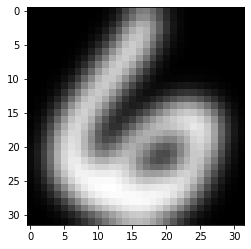

In [5]:
net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

iteration = iter(client_trainloader)

# 图片和标签（全局变量，不要覆盖）
image, label = next(iteration)

# 真实特征（全局变量，不要覆盖）
real_feature = net["extractor"](image).detach()

show_image(image)

**定义model inversion函数**

In [6]:
def model_inversion(net, feature, lambda_tv):
    x = torch.zeros((1, 1, 32, 32))
    x.requires_grad = True
    x_optimizer = optim.Adam(params=[x], lr=1e-3)

    feature_mses, image_tvs, image_mses = [], [], []
    epoch, prev_image_mse = 0, 4.
    converge_flag = False

    while True:
        x_optimizer.zero_grad()
        inversion_feature = net["extractor"](x)
        feature_mse = ((feature - inversion_feature) ** 2).sum()
        image_tv = lambda_tv * total_variation_loss(x)
        loss = feature_mse + image_tv
        loss.backward()
        x_optimizer.step()

        with torch.no_grad():
            image_mse = ((image - x) ** 2).mean()

        feature_mses.append(feature_mse.item())
        image_tvs.append(image_tv.item())
        image_mses.append(image_mse.item())
        
        if epoch%1000 == 0:
            print("epoch:%4d, feature_mse:%2.6f, image_tv:%2.6f, image_mse:%2.6f"
                %(epoch, np.mean(feature_mses), np.mean(image_tvs), np.mean(image_mses)))
            
            # 收敛条件：image_mse减少量小于1e-6
            if prev_image_mse - np.mean(image_mses) < 1e-6:
                converge_flag = True
            else:
                prev_image_mse = np.mean(image_mses)
            feature_mses, image_tvs, image_mses = [], [], []

        if converge_flag:
            break
        epoch += 1
    
    # 返回反推的图片
    return x

epoch:   0, feature_mse:61.858936, image_tv:0.000000, image_mse:0.511230
epoch:1000, feature_mse:13.783558, image_tv:0.000006, image_mse:0.347240
epoch:2000, feature_mse:0.379738, image_tv:0.000014, image_mse:0.229492
epoch:3000, feature_mse:0.093907, image_tv:0.000019, image_mse:0.187024
epoch:4000, feature_mse:0.031243, image_tv:0.000023, image_mse:0.168406
epoch:5000, feature_mse:0.011794, image_tv:0.000026, image_mse:0.159186
epoch:6000, feature_mse:0.004885, image_tv:0.000027, image_mse:0.153500
epoch:7000, feature_mse:0.002133, image_tv:0.000028, image_mse:0.148639
epoch:8000, feature_mse:0.000975, image_tv:0.000029, image_mse:0.143488
epoch:9000, feature_mse:0.000481, image_tv:0.000029, image_mse:0.137925
epoch:10000, feature_mse:0.000259, image_tv:0.000029, image_mse:0.132243
epoch:11000, feature_mse:0.000145, image_tv:0.000028, image_mse:0.126297
epoch:12000, feature_mse:0.000082, image_tv:0.000027, image_mse:0.119435
epoch:13000, feature_mse:0.000046, image_tv:0.000026, image

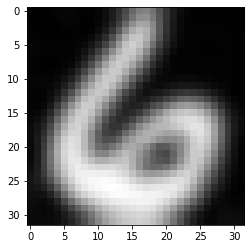

In [13]:
# 已知extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, real_feature, lambda_tv=1e-4)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(0.4888)
epoch:   0, feature_mse:62.223946, image_tv:0.000000, image_mse:0.511265
epoch:1000, feature_mse:14.867485, image_tv:0.164870, image_mse:0.310066
epoch:2000, feature_mse:0.890800, image_tv:0.229892, image_mse:0.134910
epoch:3000, feature_mse:0.467007, image_tv:0.213763, image_mse:0.077518
epoch:4000, feature_mse:0.356734, image_tv:0.213964, image_mse:0.057329
epoch:5000, feature_mse:0.314367, image_tv:0.218147, image_mse:0.051308
epoch:6000, feature_mse:0.296078, image_tv:0.222153, image_mse:0.050465
epoch:7000, feature_mse:0.288156, image_tv:0.225055, image_mse:0.051090
psnr:18.905101


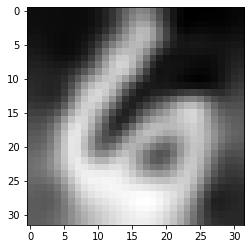

In [26]:
# 相同数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=5)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(35.5461)
epoch:   0, feature_mse:74.489571, image_tv:0.000000, image_mse:0.511279
epoch:1000, feature_mse:35.715982, image_tv:0.782666, image_mse:0.369645
epoch:2000, feature_mse:21.894577, image_tv:1.556137, image_mse:0.322067
epoch:3000, feature_mse:20.739765, image_tv:1.910134, image_mse:0.344570
psnr:10.479689


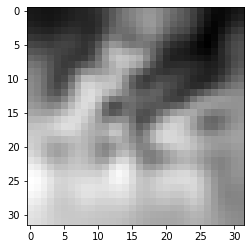

In [41]:
# 同分布数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(56.8287)
epoch:   0, feature_mse:65.377785, image_tv:0.000000, image_mse:0.511358
epoch:1000, feature_mse:39.636205, image_tv:1.102432, image_mse:0.371673
epoch:2000, feature_mse:28.172236, image_tv:2.407578, image_mse:0.308766
epoch:3000, feature_mse:27.026717, image_tv:2.726459, image_mse:0.294994
epoch:4000, feature_mse:26.614291, image_tv:3.011829, image_mse:0.303995
psnr:11.116520


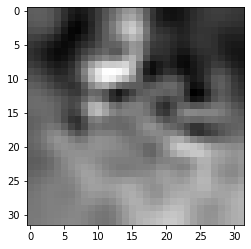

In [44]:
# 不同分布数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

In [59]:
# z 和 image 配对 (最小化fake feature和real feature的mse)

net = nn.ModuleDict()
net["generator"] = Generator()            
frozen_net(net, ["generator"], True)

G_checkpoint = torch.load("./checkpoint/client_generator.pkl", map_location=torch.device('cpu'))
net["generator"].load_state_dict(G_checkpoint)

# 优化z
z = torch.zeros((1, 100, 1, 1))
z.requires_grad = True
z_optimizer = optim.Adam(params=[z], lr=1e-3)

feature_mses = []
epoch, prev_loss = 0, 10000.
converge_flag = False
while True:
    z_optimizer.zero_grad()
    inversion_feature = net["generator"](z, label)
    feature_mse = ((real_feature - inversion_feature) ** 2).sum()
    feature_mse.backward()
    z_optimizer.step()

    feature_mses.append(feature_mse.item())

    if epoch%1000 == 0:
        print("epoch:%4d, feature_mse:%2.6f"%(epoch, np.mean(feature_mses)))
        if prev_loss - np.mean(feature_mses) < 1e-6:
            converge_flag = True
        else:
            prev_loss = np.mean(feature_mses)
        feature_mses = []

    if converge_flag:
        break
    epoch += 1

# 最接近真实feature的虚假feature（全局变量，不要覆盖）
fake_feature = net["generator"](z, label).detach()

epoch:   0, feature_mse:34.189785
epoch:1000, feature_mse:6.951728
epoch:2000, feature_mse:2.253874
epoch:3000, feature_mse:1.709658
epoch:4000, feature_mse:1.424024
epoch:5000, feature_mse:1.190999
epoch:6000, feature_mse:1.021837
epoch:7000, feature_mse:0.898690
epoch:8000, feature_mse:0.815004
epoch:9000, feature_mse:0.745438
epoch:10000, feature_mse:0.691329
epoch:11000, feature_mse:0.649852
epoch:12000, feature_mse:0.612465
epoch:13000, feature_mse:0.584217
epoch:14000, feature_mse:0.568060
epoch:15000, feature_mse:0.563125
epoch:16000, feature_mse:0.558515
epoch:17000, feature_mse:0.553263
epoch:18000, feature_mse:0.550040
epoch:19000, feature_mse:0.547780
epoch:20000, feature_mse:0.547050
epoch:21000, feature_mse:0.546638
epoch:22000, feature_mse:0.546238
epoch:23000, feature_mse:0.545857
epoch:24000, feature_mse:0.545705
epoch:25000, feature_mse:0.545554
epoch:26000, feature_mse:0.545320
epoch:27000, feature_mse:0.545218
epoch:28000, feature_mse:0.545193
epoch:29000, feature_ms

epoch:   0, feature_mse:60.413013, image_tv:0.000000, image_mse:0.511220
epoch:1000, feature_mse:13.599442, image_tv:0.166001, image_mse:0.327813
epoch:2000, feature_mse:0.597463, image_tv:0.205149, image_mse:0.165534
epoch:3000, feature_mse:0.328517, image_tv:0.175639, image_mse:0.102043
epoch:4000, feature_mse:0.270903, image_tv:0.165416, image_mse:0.079317
epoch:5000, feature_mse:0.253638, image_tv:0.162418, image_mse:0.072004
epoch:6000, feature_mse:0.248019, image_tv:0.161554, image_mse:0.069823
epoch:7000, feature_mse:0.246240, image_tv:0.161391, image_mse:0.069273
epoch:8000, feature_mse:0.245708, image_tv:0.161452, image_mse:0.069212
epoch:9000, feature_mse:0.245545, image_tv:0.161532, image_mse:0.069258
psnr:17.614799


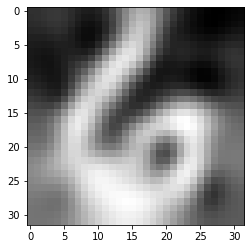

In [51]:
# 已知extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=5)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:60.680016, image_tv:0.000000, image_mse:0.511274
epoch:1000, feature_mse:14.533345, image_tv:0.164442, image_mse:0.318223
epoch:2000, feature_mse:0.985967, image_tv:0.228207, image_mse:0.150048
epoch:3000, feature_mse:0.593194, image_tv:0.213655, image_mse:0.093373
epoch:4000, feature_mse:0.494767, image_tv:0.214047, image_mse:0.073589
epoch:5000, feature_mse:0.458237, image_tv:0.217501, image_mse:0.067731
epoch:6000, feature_mse:0.442662, image_tv:0.220819, image_mse:0.066683
epoch:7000, feature_mse:0.435881, image_tv:0.223381, image_mse:0.066890
psnr:17.756972


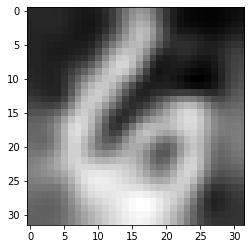

In [52]:
# 相同数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=5)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:73.200325, image_tv:0.000000, image_mse:0.511268
epoch:1000, feature_mse:34.939991, image_tv:0.778065, image_mse:0.370344
epoch:2000, feature_mse:21.270838, image_tv:1.575218, image_mse:0.322468
epoch:3000, feature_mse:20.102678, image_tv:1.938004, image_mse:0.344959
psnr:10.464058


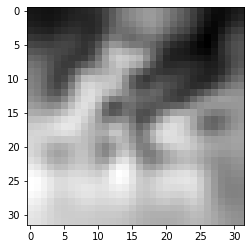

In [55]:
# 同分布数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:64.083832, image_tv:0.000000, image_mse:0.511352
epoch:1000, feature_mse:38.944060, image_tv:1.011001, image_mse:0.365361
epoch:2000, feature_mse:27.668836, image_tv:2.158030, image_mse:0.311022
epoch:3000, feature_mse:26.591404, image_tv:2.502901, image_mse:0.302355
epoch:4000, feature_mse:26.353944, image_tv:2.638456, image_mse:0.307148
psnr:11.102064


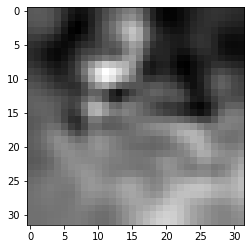

In [58]:
# 不同分布数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)